<a href="https://colab.research.google.com/github/qorganbek/ComputerVision-Spring-2024/blob/main/lab10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
from itertools import groupby

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
from Levenshtein import distance
from difflib import SequenceMatcher

In [ ]:
epochs = 18
num_classes = 11
blank_label = 10
image_height = 28
gru_hidden_size = 128

gru_num_layers = 2
cnn_output_height = 4
cnn_output_width = 32
#digits_per_sequence = 5
number_of_sequences = 10000
#emnist_dataset = datasets.EMNIST('./EMNIST', split="digits", train=True, download=False)
dataset_sequences = []
dataset_labels = []



In [ ]:
from emnist import extract_training_samples
images, labels = extract_training_samples('digits')
images.shape


(240000, 28, 28)

In [ ]:
random_sequence.shape

(28, 168)

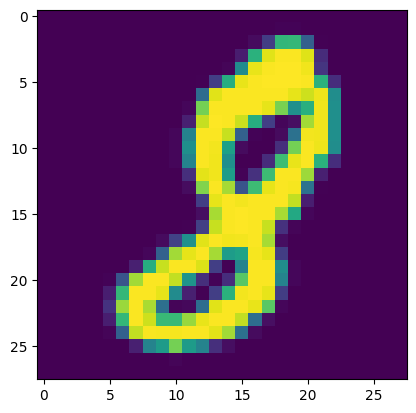

In [ ]:
plt.imshow(images[0])

In [ ]:
for i in range(number_of_sequences):
    digits_per_sequence = np.random.randint(5,10)
    to_add = 10-digits_per_sequence
    random_indices = np.random.randint(len(images), size=(digits_per_sequence,))
    zero_images = np.zeros((to_add, 28, 28), dtype=np.float32)
    random_digits_images = np.concatenate((images[random_indices], zero_images), axis=0)

    transformed_random_digits_images = []

    for img in random_digits_images:
        img = transforms.ToPILImage()(img)
        img = TF.rotate(img, -90, fill=0)
        img = TF.hflip(img)
        img = transforms.RandomAffine(degrees=10, translate=(0.2, 0.15), scale=(0.8, 1.1))(img)
        img = transforms.ToTensor()(img).numpy()
        transformed_random_digits_images.append(img)

    zero_labels = np.full(to_add, blank_label, dtype=np.uint8)
    random_digits_images = np.array(transformed_random_digits_images)
    random_digits_labels = np.concatenate((labels[random_indices], zero_labels), axis=0)
    random_sequence = np.hstack(random_digits_images.reshape(10, 28, 28))
    random_labels = np.hstack(random_digits_labels.reshape(10, 1))
    dataset_sequences.append(random_sequence / 255)
    dataset_labels.append(random_labels)

dataset_data = torch.Tensor(np.array(dataset_sequences))
dataset_labels = torch.IntTensor(np.array(dataset_labels))

seq_dataset = data_utils.TensorDataset(dataset_data, dataset_labels)
train_set, val_set = torch.utils.data.random_split(seq_dataset,
                                                   [int(len(seq_dataset) * 0.8), int(len(seq_dataset) * 0.2)])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True)

In [ ]:
class CRNN(nn.Module):

    def __init__(self):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3))
        self.norm1 = nn.InstanceNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2)
        self.norm2 = nn.InstanceNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.norm3 = nn.InstanceNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=2)
        self.norm4 = nn.InstanceNorm2d(64)
        self.gru_input_size = cnn_output_height * 64
        self.gru = nn.GRU(self.gru_input_size, gru_hidden_size, gru_num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(gru_hidden_size * 2, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = self.norm1(out)
        out = F.leaky_relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = F.leaky_relu(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out = F.leaky_relu(out)
        out = self.conv4(out)
        out = self.norm4(out)
        out = F.leaky_relu(out)
        out = out.permute(0, 3, 2, 1)
        out = out.reshape(batch_size, -1, self.gru_input_size)
        out, _ = self.gru(out)
        out = torch.stack([F.log_softmax(self.fc(out[i]), dim=-1) for i in range(out.shape[0])])
        return out

In [ ]:
model = CRNN().cuda()
criterion = nn.CTCLoss(blank=blank_label, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def OCRaccuracy(ground_truth, predicted):
    sm = SequenceMatcher(None, predicted, ground_truth)
    true_positive_char_num = 0
    for tag, i1, i2, j1, j2 in sm.get_opcodes():
        if tag== 'equal':
            true_positive_char_num += (j2 - j1)
        else:
            pass

    accuracy = true_positive_char_num/len(ground_truth)
    return accuracy


In [ ]:
for _ in range(epochs):
    running_loss = 0.0
    acc = 0
    for x_train, y_train in tqdm(train_loader,
                                 position=0, leave=True,
                                 file=sys.stdout):
        batch_size = x_train.shape[0]  # x_train.shape == torch.Size([64, 28, 140])
        x_train = x_train.view(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
        optimizer.zero_grad()
        y_pred = model(x_train.cuda())
        y_pred = y_pred.permute(1, 0, 2)  # y_pred.shape == torch.Size([64, 32, 11])
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len([label for label in t if label != blank_label]) for t in y_train])
        loss = criterion(y_pred, y_train, input_lengths, target_lengths)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        _, max_index = torch.max(y_pred, dim=2)  # max_index.shape == torch.Size([32, 64])

        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())  # len(raw_prediction) == 32
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
            non_blank_mask = y_train[i] != blank_label
            tar = y_train[i][non_blank_mask]
            acc += OCRaccuracy(tar,prediction)/batch_size

    print(f'TRAINING. loss: {running_loss:.2f}')
    print(f'TRAINING. accuracy: {(acc/125)*100:.2f}')

100%|████████████████████████████████████████████████████████| 125/125 [00:08<00:00, 14.40it/s]
TRAINING. loss: 320.28
TRAINING. accuracy: 0.16
100%|████████████████████████████████████████████████████████| 125/125 [00:08<00:00, 13.89it/s]
TRAINING. loss: 193.48
TRAINING. accuracy: 26.30
100%|████████████████████████████████████████████████████████| 125/125 [00:09<00:00, 13.51it/s]
TRAINING. loss: 80.99
TRAINING. accuracy: 67.54
100%|████████████████████████████████████████████████████████| 125/125 [00:09<00:00, 13.54it/s]
TRAINING. loss: 56.72
TRAINING. accuracy: 74.34
100%|████████████████████████████████████████████████████████| 125/125 [00:09<00:00, 13.55it/s]
TRAINING. loss: 44.79
TRAINING. accuracy: 78.14
100%|████████████████████████████████████████████████████████| 125/125 [00:09<00:00, 13.55it/s]
TRAINING. loss: 35.68
TRAINING. accuracy: 81.42
100%|████████████████████████████████████████████████████████| 125/125 [00:09<00:00, 13.51it/s]
TRAINING. loss: 30.14
TRAINING. accurac

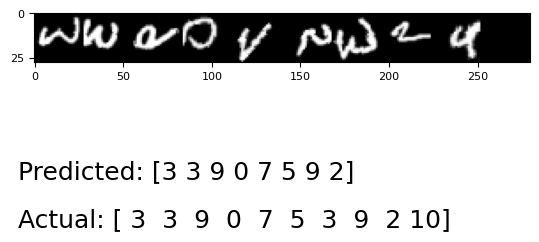

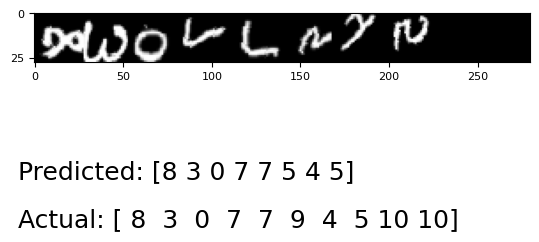

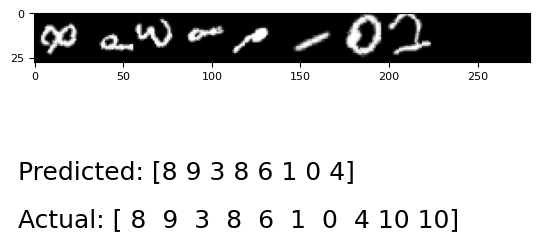

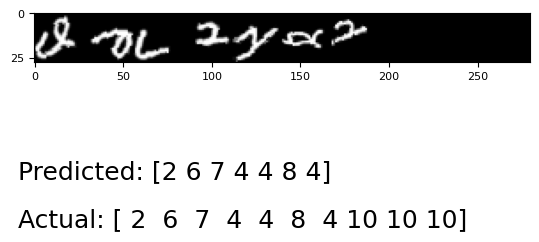

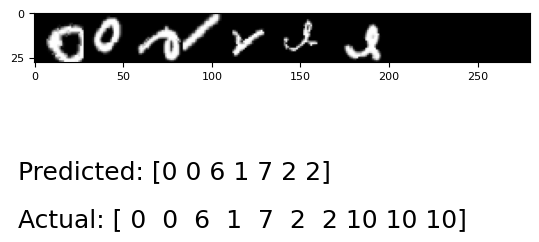

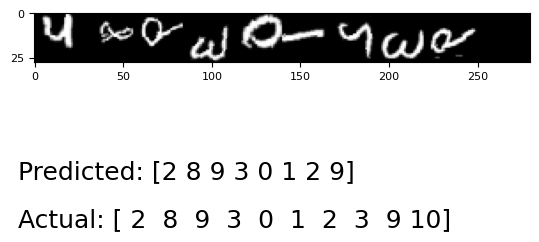

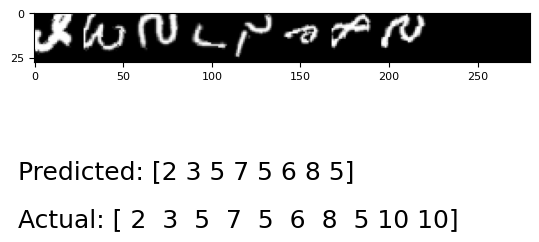

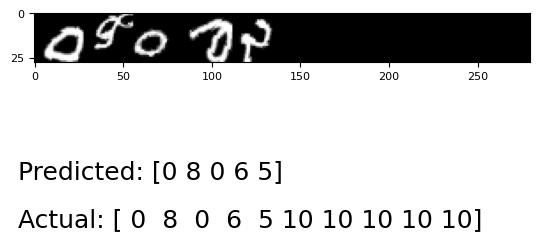

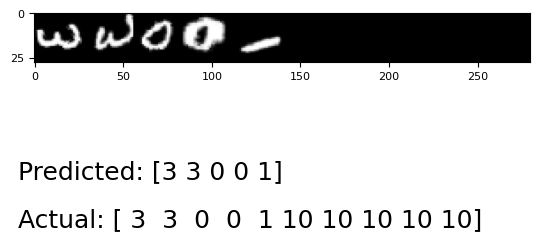

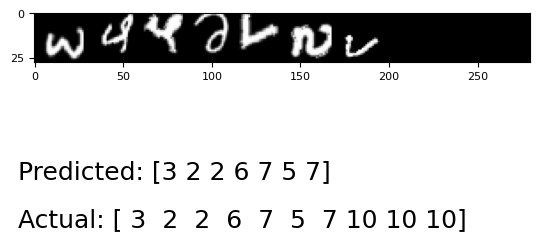

In [ ]:
number_of_test_imgs = 10
test_loader = torch.utils.data.DataLoader(val_set, batch_size=number_of_test_imgs, shuffle=True)
test_preds = []
(x_test, y_test) = next(iter(test_loader))
y_pred = model(x_test.view(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]).cuda())
y_pred = y_pred.permute(1, 0, 2)
_, max_index = torch.max(y_pred, dim=2)
for i in range(x_test.shape[0]):
    raw_prediction = list(max_index[:, i].detach().cpu().numpy())
    prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
    test_preds.append(prediction)

for j in range(len(x_test)):
    mpl.rcParams["font.size"] = 8
    plt.imshow(x_test[j], cmap='gray')
    mpl.rcParams["font.size"] = 18
    plt.gcf().text(x=0.1, y=0.1, s="Actual: " + str(y_test[j].numpy()))
    plt.gcf().text(x=0.1, y=0.2, s="Predicted: " + str(test_preds[j].numpy()))
    plt.show()

In [ ]:
#Task rerun this code for length of sequence from 5 to 10 and calculate metrics (you can choose is by you own for test data)
#replace accuracy function